# View data

In [6]:
SEED = 42



from utils import *
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%pip install nltk

## Load Data

In [7]:
vocab_kos = load_vocabulary("data/bag+of+words/vocab.kos.txt")
vocab_nips = load_vocabulary("data/bag+of+words/vocab.nips.txt")
display(len(vocab_kos))
display(len(vocab_nips))

6906

12419

In [8]:
counts_matrix_kos = load_docwords("data/bag+of+words/docword.kos.txt")
counts_matrix_nips = load_docwords("data/bag+of+words/docword.nips.txt")

3430 6906 353160
1500 12419 746316


In [9]:
counts_matrix_nips

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
tfdidf_transformer = TfidfTransformer()
tf_idf_matrix_kos = tfdidf_transformer.fit_transform(counts_matrix_kos)
tf_idf_matrix_nips = tfdidf_transformer.fit_transform(counts_matrix_nips)

## Vocabulary Lemmatization - TODO

In [45]:
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatized_vocabulary = []

for word in vocab_nips:
    lemmatized_word = lemmatizer.lemmatize(word)
    # if lemmatized_word != word:
    #     print(word, lemmatized_word)
    lemmatized_vocabulary.append(lemmatized_word)

print(len(lemmatized_vocabulary), len(set(lemmatized_vocabulary))) #1000 words less -> lower dimension -> better dimred??
print(lemmatized_vocabulary)

12419 11922
['a2i', 'aaa', 'aaai', 'aapo', 'aat', 'aazhang', 'abandonment', 'abbott', 'abbreviated', 'abcde', 'abe', 'abele', 'abi', 'abilistic', 'ability', 'ability', 'abl', 'able', 'ables', 'ablex', 'ably', 'abnormal', 'abort', 'abound', 'abramowicz', 'abrash', 'abrupt', 'abruptly', 'abscissa', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbing', 'absorption', 'abstr', 'abstract', 'abstracted', 'abstraction', 'abu', 'abundance', 'aca', 'acad', 'academic', 'academy', 'acc', 'accelerate', 'accelerated', 'accelerating', 'acceleration', 'accelerator', 'accent', 'accept', 'acceptable', 'acceptably', 'acceptance', 'accepted', 'accepting', 'acceptor', 'access', 'accessed', 'accessible', 'accessing', 'accommodate', 'accommodated', 'accomodate', 'accompanied', 'accompanying', 'accomplish', 'accomplished', 'accomplishes', 'accord', 'accordance', 'according', 'account', 'accounted', 'accounting', 'accu', 'accumulate', 'accumulated', 'accumulates', 'accumulating', 'a

[nltk_data] Downloading package wordnet to /home/mlynatom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
mapping = {}
lemma_kos = list(np.unique(lemmatized_vocabulary))
print(len(lemma_kos))
for i, word in enumerate(vocab_kos):
    idx_in_new = lemma_kos.index(lemmatizer.lemmatize(word))
    mapping[i] = idx_in_new



5983


In [32]:
with open("data/bag+of+words/docword.kos.txt", "r") as f:
    n_docs = int(f.readline().strip())
    n_words = int(f.readline().strip())
    n_words = len(lemma_kos)
    n_nonzero_counts = int(f.readline().strip())
    print(n_docs, n_words, n_nonzero_counts)
    counts_lemma_kos = np.zeros((n_docs, n_words))
    for line in f:
        split_line = line.strip().split(" ")
        word_id = int(split_line[1])-1
        new_word_id = mapping[word_id]
        counts_lemma_kos[int(split_line[0])-1, new_word_id] += int(split_line[2])

3430 5983 353160


In [33]:
counts_lemma_kos

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
tf_idf_matrix_kos_lemma = tfdidf_transformer.fit_transform(counts_lemma_kos)

## Dimension Reduction

In [27]:
%pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 KB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 3.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 3.5 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#umap
import umap
#lsp
import matplotlib.pyplot as plt

In [19]:
def reduce_dim(reducer, data, colour=None, cmap=None, verbose=False):
    reduced_matrix = reducer.fit_transform(data)
    if verbose:
        display(reduced_matrix)

    scatter = plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=colour, cmap=cmap, s=2)
    if colour is not None:
        plt.legend(*scatter.legend_elements())

### PCA

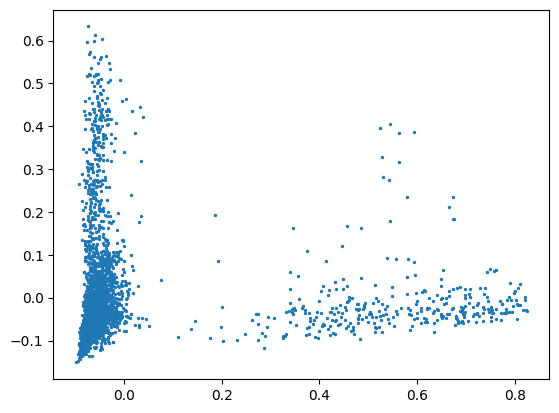

In [23]:
reduce_dim(PCA(n_components=2, svd_solver="arpack"), tf_idf_matrix_kos)


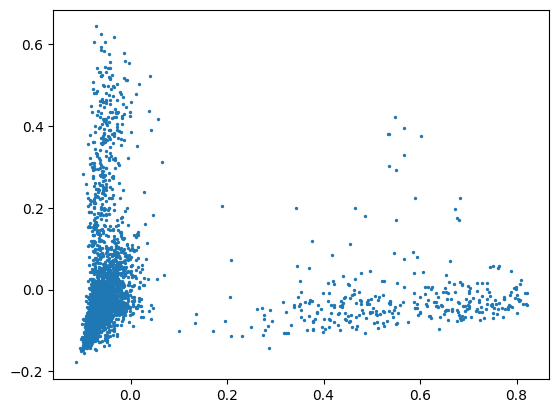

In [37]:
reduce_dim(PCA(n_components=2, svd_solver="arpack"), tf_idf_matrix_kos_lemma)

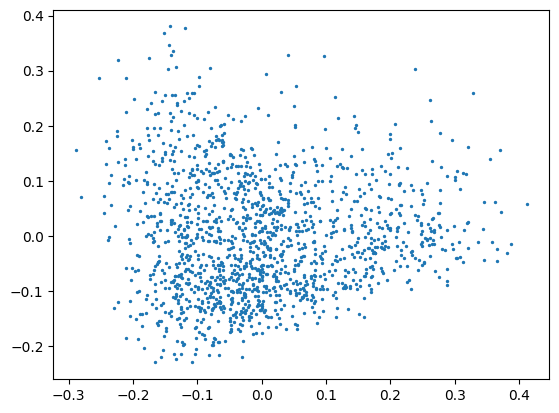

In [24]:
reduce_dim(PCA(n_components=2, svd_solver="arpack"), tf_idf_matrix_nips)

### t-SNE

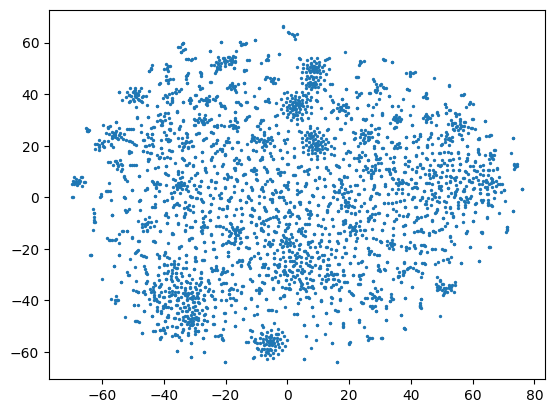

In [25]:
reduce_dim(TSNE(n_components=2, init="random", random_state=SEED), tf_idf_matrix_kos)

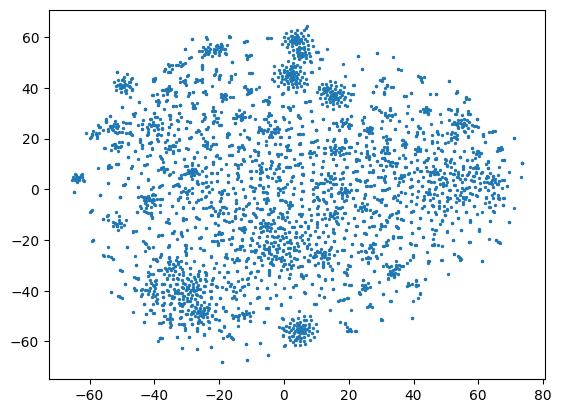

In [39]:
reduce_dim(TSNE(n_components=2, init="random", random_state=SEED), tf_idf_matrix_kos_lemma)

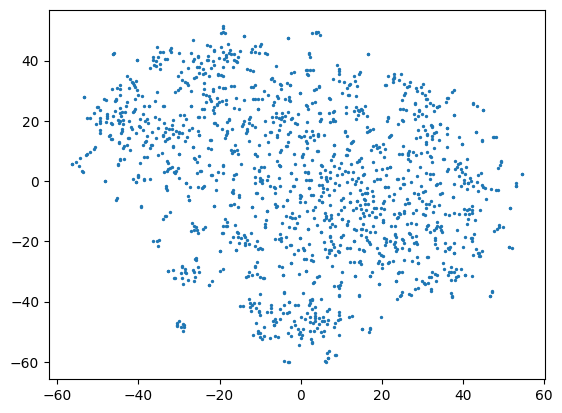

In [26]:
reduce_dim(TSNE(n_components=2, init="random", random_state=SEED), tf_idf_matrix_nips)

### UMAP

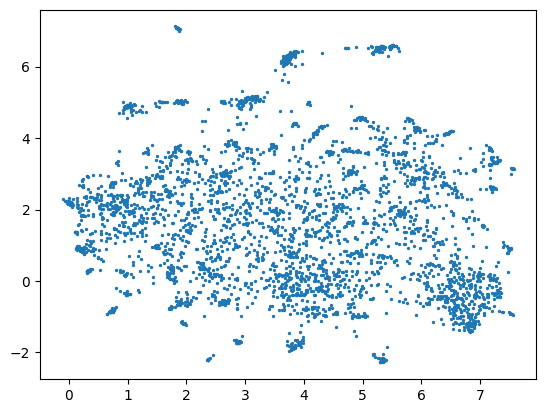

In [31]:
#many hyperparams!
reduce_dim(umap.UMAP(n_components=2), tf_idf_matrix_kos)

/home/mlynatom/viz/project/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


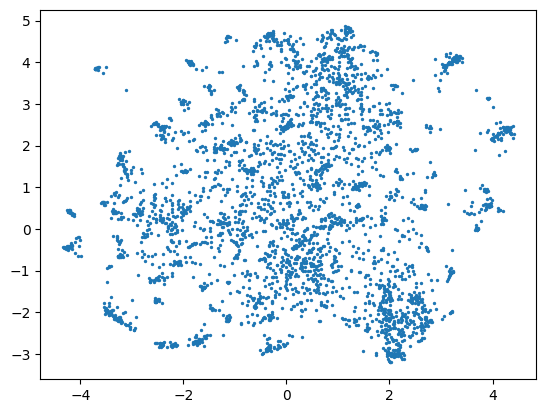

In [40]:
reduce_dim(umap.UMAP(n_components=2), tf_idf_matrix_kos_lemma)

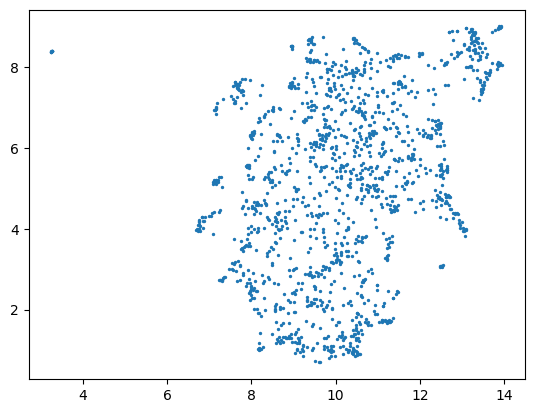

In [42]:
reduce_dim(umap.UMAP(n_components=2), tf_idf_matrix_nips)

### LSP

not working (https://github.com/hhliz/LSP)

## Topic Modelling

In [84]:
def get_words(topic_words_matrix, vocabulary, n=5):
    for i in range(topic_words_matrix.shape[0]):
        ind =  np.argpartition(topic_words_matrix[i, :], -n)[-n:]

        words = [vocabulary[word_id] for word_id in ind]
        print(i, words) 

### Latent Dirichlet Allocation

Topic Modelling

In [11]:
from sklearn.decomposition import LatentDirichletAllocation

lda_kos = LatentDirichletAllocation(n_components=10, random_state=SEED)

X_new_kos = lda_kos.fit_transform(counts_matrix_kos)
lda_nips = LatentDirichletAllocation(n_components=10, random_state=SEED)
X_new_nips = lda_nips.fit_transform(counts_matrix_nips)

In [12]:
themes_kos = np.argmax(X_new_kos, axis=1)
themes_nips = np.argmax(X_new_nips, axis=1)

In [85]:
get_words(lda_kos.components_, vocab_kos, n=5)

0 ['billion', 'tax', 'deficit', 'budget', 'bush']
1 ['governor', 'electoral', 'house', 'poll', 'november']
2 ['primary', 'democratic', 'kerry', 'edwards', 'dean']
3 ['war', 'kerry', 'administration', 'bush', 'president']
4 ['american', 'iraqi', 'war', 'iraq', 'bush']
5 ['time', 'people', 'party', 'political', 'media']
6 ['general', 'percent', 'poll', 'kerry', 'bush']
7 ['house', 'senate', 'republican', 'race', 'democrats']
8 ['republicans', 'texas', 'delay', 'house', 'bush']
9 ['general', 'officials', 'people', 'war', 'military']


In [86]:
get_words(lda_nips.components_, vocab_nips, n=5)

0 ['word', 'speech', 'recognition', 'system', 'network']
1 ['error', 'parameter', 'function', 'network', 'model']
2 ['tree', 'set', 'training', 'model', 'data']
3 ['problem', 'policy', 'function', 'algorithm', 'learning']
4 ['dynamic', 'system', 'model', 'learning', 'control']
5 ['analog', 'neural', 'chip', 'network', 'circuit']
6 ['system', 'model', 'neuron', 'cell', 'input']
7 ['learning', 'vector', 'data', 'set', 'algorithm']
8 ['weight', 'unit', 'input', 'network', 'learning']
9 ['field', 'object', 'visual', 'cell', 'model']


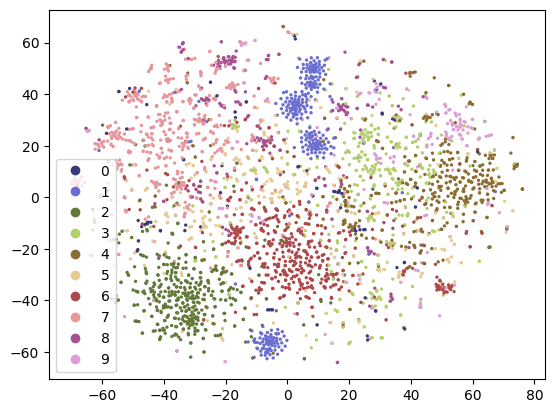

In [20]:
reduce_dim(TSNE(n_components=2, init="random", random_state=SEED), tf_idf_matrix_kos, colour=themes_kos, cmap="tab20b")

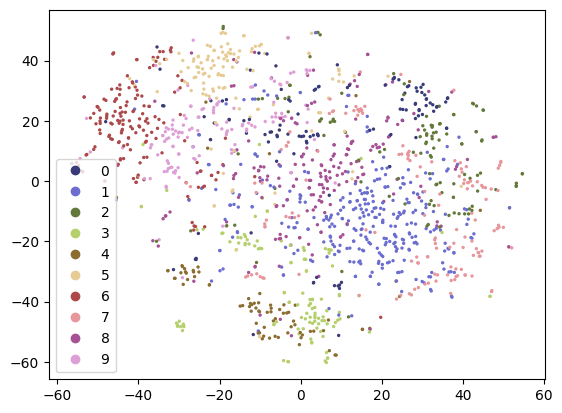

In [21]:
reduce_dim(TSNE(n_components=2, init="random", random_state=SEED), tf_idf_matrix_nips, colour=themes_nips, cmap="tab20b")

### NMF

In [56]:
from sklearn.decomposition import NMF, MiniBatchNMF

nmf

In [76]:
nmf_kos = NMF(n_components=10, random_state=SEED)
nmf_nips = NMF(n_components=10, random_state=SEED)

In [77]:
W_kos = nmf_kos.fit_transform(tf_idf_matrix_kos) #documents # topics
H_kos = nmf_kos.components_ #topics x words
W_nips = nmf_nips.fit_transform(tf_idf_matrix_nips) #documents # topics
H_nips = nmf_nips.components_ #topics x words

In [78]:
topics_nmf_kos = np.argmax(W_kos, axis=1)
topics_nmf_nips = np.argmax(W_nips, axis=1)

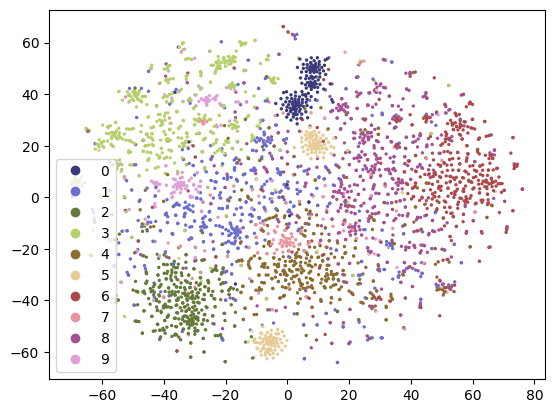

In [75]:
reduce_dim(TSNE(n_components=2, init="random", random_state=SEED), tf_idf_matrix_kos, colour=topics_nmf_kos, cmap="tab20b")

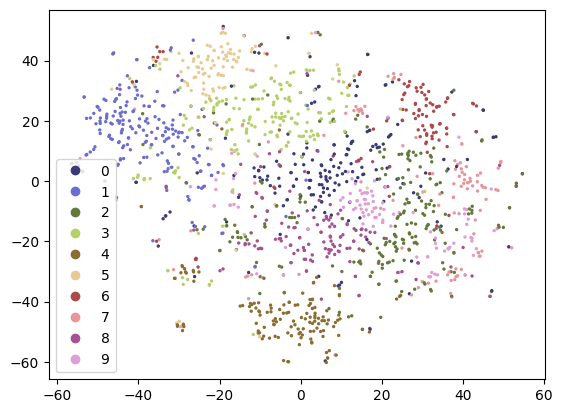

In [48]:
reduce_dim(TSNE(n_components=2, init="random", random_state=SEED), tf_idf_matrix_nips, colour=topics_nmf_nips, cmap="tab20b")

In [91]:
get_words(H_kos, vocabulary=vocab_kos, n=5)

0 ['governor', 'electoral', 'account', 'november', 'voting']
1 ['people', 'campaign', 'democratic', 'party', 'ballot']
2 ['gephardt', 'lieberman', 'edwards', 'clark', 'dean']
3 ['seat', 'elections', 'race', 'house', 'senate']
4 ['polls', 'general', 'poll', 'bush', 'kerry']
5 ['parecommend', 'electoral', 'account', 'turnout', 'november']
6 ['troops', 'military', 'iraqi', 'war', 'iraq']
7 ['numbers', 'vote', 'poll', 'percent', 'voters']
8 ['white', 'cheney', 'administration', 'president', 'bush']
9 ['raised', 'donors', 'million', 'money', 'campaign']


In [92]:
get_words(H_nips, vocabulary=vocab_nips, n=5)

0 ['weight', 'input', 'hidden', 'unit', 'network']
1 ['synaptic', 'firing', 'neuron', 'spike', 'cell']
2 ['likelihood', 'distribution', 'data', 'gaussian', 'model']
3 ['motion', 'visual', 'image', 'object', 'images']
4 ['control', 'reinforcement', 'action', 'learning', 'policy']
5 ['vlsi', 'voltage', 'analog', 'circuit', 'chip']
6 ['speaker', 'hmm', 'speech', 'word', 'recognition']
7 ['data', 'set', 'classifier', 'classification', 'training']
8 ['generalization', 'training', 'weight', 'learning', 'error']
9 ['threshold', 'polynomial', 'bound', 'function', 'theorem']


### Max tfidf

In [53]:
themes_kos

array([3, 3, 1, ..., 5, 7, 7])

In [65]:
np.array(tf_idf_matrix_kos.todense())

array([[0.        , 0.        , 0.        , ..., 0.        , 0.08710494,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [69]:
max_kos = np.argmax(np.array(tf_idf_matrix_kos.todense()), axis=1)

In [73]:
np.unique(max_kos).shape

(1675,)